In [45]:
import ast
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle

In [2]:
ents = pd.read_pickle(os.getcwd() + '/Pickle/all_entities.pkl')
ents.shape

(284500, 13)

In [3]:
rels = pd.read_pickle(os.getcwd() + '/Pickle/all_rels.pkl')
rels.shape

(1230815, 15)

In [4]:
filtered_data = pd.read_pickle(os.getcwd() + '/Pickle/filtered_org_match.pkl')
filtered_data.shape

(7454, 18)

In [4]:
matched_names_res = {}

with open(os.getcwd() + '/Pickle/matched_names.pickle', 'rb') as pkl:
    matched_names_res = pickle.load(pkl)
    
matched_name_df = pd.DataFrame(list(matched_names_res.items())).rename(columns = {0: 'ls_id', 1: 'bp_id'})  # create df of matched name IDs
matched_name_df.shape

(118659, 2)

In [5]:
matched_name_df_exploded = matched_name_df.explode('bp_id')
matched_name_df_exploded.head()

,ls_id,bp_id
0,262146,998678
1,262147,636330
2,262150,934460
2,262150,3191192
3,262154,638094


In [6]:
bipartite_all = nx.read_gpickle(os.getcwd() + '/Pickle/bipartite-all010420.pickle')
bipartite_all.number_of_nodes()

4054832

In [8]:
filtered_data.head()[['ls_id', 'bp_id', 'ls_rels', 'bp_rels']]

,ls_id,bp_id,ls_rels,bp_rels
1236,14713,6822486,711,9
1252,14730,6830462,931,7
1284,14922,8904282,18,5
1285,14924,7871420,406,18
1286,14925,7513160,147,34


#### Forward Matching

i.e. Adding to LittleSis

In [9]:
# x is the current org
def forwardMatch(x_ls_id):
    x_bp_id = filtered_data[filtered_data['ls_id'] == x_ls_id]['bp_id'].iloc[0]  # get corresponding bp_id
    
    # get 'person' relationships for x from LittleSis
    x_ls_rels = rels[rels['entity1_id'].isin([x_ls_id]) | rels['entity2_id'].isin([x_ls_id])]  # all LittleSis relations for x
    related_to_x_ls_id = x_ls_rels[x_ls_rels['entity1_id'] != x_ls_id]['entity1_id'].append(x_ls_rels[x_ls_rels['entity2_id'] != x_ls_id]['entity2_id']).unique()  # LittleSis IDs for all ents related to x
    related_to_x_ls = ents[ents['id'].isin(related_to_x_ls_id)]
    related_to_x_ls_names = related_to_x_ls[related_to_x_ls['primary_ext'] == 'Person'][['id', 'name']].rename(columns = {'id': 'ls_id'})
    related_to_x_ls_names.reset_index(drop = True, inplace = True)
    
    if related_to_x_ls_names.shape[0] == 0:  # if true return none else continue
        return None
    
    # get 'person' relationships for x from bipartite-all
    related_to_x_bp = {}
    
    for i in bipartite_all[x_bp_id]:
        related_to_x_bp[i] = bipartite_all.nodes[i]['name']
        
    related_to_x_bp_names = pd.DataFrame(list(related_to_x_bp.items())).rename(columns = {0: 'bp_id', 1: 'name'})
    
    all_x_matches = matched_name_df[matched_name_df['ls_id'].isin(related_to_x_ls_names['ls_id'])]
    all_x_matches_exploded = all_x_matches.explode('bp_id')
    
    final = all_x_matches_exploded[all_x_matches_exploded['bp_id'].isin(related_to_x_bp_names['bp_id'])].set_index('ls_id').join(related_to_x_ls_names.set_index('ls_id'), on = 'ls_id', lsuffix = '_left', rsuffix = '_right').reset_index().set_index('bp_id').join(related_to_x_bp_names.set_index('bp_id'), on = 'bp_id', lsuffix = '_ls', rsuffix = '_bp').reset_index()
    
#     print(final.to_dict())

    return final.to_dict()

In [8]:
abc = filtered_data[filtered_data['ls_id'].isin([15367, 33551])].copy()  # sample data for trying matching
abc

#### Reverse Matching

i.e. Adding to bipartite-all data

In [11]:
# x is the current org
def reverseMatch(x_ls_id):
    x_bp_id = filtered_data[filtered_data['ls_id'] == x_ls_id]['bp_id'].iloc[0]  # get corresponding bp_id
    
    # get 'person' relationships for x from LittleSis
    x_ls_rels = rels[rels['entity1_id'].isin([x_ls_id]) | rels['entity2_id'].isin([x_ls_id])]  # all LittleSis relations for x
    related_to_x_ls_id = x_ls_rels[x_ls_rels['entity1_id'] != x_ls_id]['entity1_id'].append(x_ls_rels[x_ls_rels['entity2_id'] != x_ls_id]['entity2_id']).unique()  # LittleSis IDs for all ents related to x
    related_to_x_ls = ents[ents['id'].isin(related_to_x_ls_id)]
    related_to_x_ls_names = related_to_x_ls[related_to_x_ls['primary_ext'] == 'Person'][['id', 'name']].rename(columns = {'id': 'ls_id'})
    related_to_x_ls_names.reset_index(drop = True, inplace = True)
    
    if related_to_x_ls_names.shape[0] == 0:  # if true return none else continue
        return None
    
    # get 'person' relationships for x from bipartite-all
    related_to_x_bp = {}
    
    for i in bipartite_all[x_bp_id]:
        related_to_x_bp[i] = bipartite_all.nodes[i]['name']
        
    related_to_x_bp_names = pd.DataFrame(list(related_to_x_bp.items())).rename(columns = {0: 'bp_id', 1: 'name'})
    
    all_x_matches_rev = matched_name_df_exploded[matched_name_df_exploded['bp_id'].isin(related_to_x_bp_names['bp_id'])]
    final = all_x_matches_rev.set_index('ls_id').join(ents.rename(columns = {'id': 'ls_id'}).set_index('ls_id'), on = 'ls_id', lsuffix = '_left', rsuffix = '_right').reset_index().set_index('bp_id').join(related_to_x_bp_names.set_index('bp_id'), on = 'bp_id', lsuffix = '_ls', rsuffix = '_bp').reset_index()[['bp_id', 'ls_id', 'name_ls', 'name_bp']]
    
    return final.to_dict()

In [12]:
abc['rev'] = abc['ls_id'].apply(reverseMatch)
abc

,ls_id,name,bp_id,match_name,match_value,summary,parent_id,extensions,website,primary_ext,aliases,blurb,types,updated_at,start_date,end_date,ls_rels,bp_rels,rev
1435,15367,NORTHEASTERN UNIVERSITY,6819740,NORTHEASTERN UNIVERSITY,1.0,None,NaN,"{'Org': {'name_nick': None, 'name': 'Northeast...",None,Org,[Northeastern University],None,"[Organization, School]",2020-06-15T21:58:42Z,None,None,79,69,"{'bp_id': {0: 112459, 1: 295562, 2: 252548, 3:..."
6493,33551,BILL & MELINDA GATES FOUNDATION,7863433,BILL & MELINDA GATES FOUNDATION,1.0,None,NaN,"{'Org': {'name_nick': None, 'name': 'Bill & Me...",None,Org,"[Bill & Melinda Gates Foundation, Bill and Mel...",Family foundation of Microsoft founder Bill Gates,"[Organization, Philanthropy]",2020-07-14T02:25:29Z,None,None,420,19,"{'bp_id': {0: 809124, 1: 516547, 2: 2725019, 3..."


In [13]:
filtered_data['rev'] = filtered_data['ls_id'].appy(reverseMatch)

Save results:

In [14]:
# filtered_data.to_pickle(os.getcwd() + '/Pickle/filtered_org_match_rev.pkl')
# print('Done')

#### Analysing Results

In [22]:
# fil_dat_rev = pd.read_pickle(os.getcwd() + '/Pickle/filtered_org_match_rev.pkl')  # filtered_data with the rev column
fil_dat_rev = pd.read_csv(os.getcwd() + '/Data/filtered_org_match_rev.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
fil_dat_rev.shape

(7426, 19)

Note the following changes:

1. filtered_data['bp_id'][114] = 7286871  #corrected CMU
2. filtered_data['match_name'][114] = 'CARNEGIE MELLON UNIVERSITY (CMU)'
3. filtered_data['bp_id'][854]= 8425574  #corrected kaiser family foundation

In [62]:
fil_dat_rev.iloc[114, 2]

7286871

In [63]:
fil_dat_rev[fil_dat_rev['bp_id'] == 7286871]

,ls_id,name,bp_id,match_name,match_value,summary,parent_id,extensions,website,primary_ext,aliases,blurb,types,updated_at,start_date,end_date,ls_rels,bp_rels,rev,rev_len
114,15268,CARNEGIE MELLON UNIVERSITY,7286871,CARNEGIE MELLON UNIVERSITY (CMU),0.847541,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Carnegie ...",NaN,Org,"['Carnegie Mellon', 'Carnegie Mellon Universit...","Private research university in Pittsburgh, fou...","['Organization', 'School']",2020-07-12T14:23:20Z,NaN,NaN,143,0,"{'bp_id': {0: 200653, 1: 2680072, 2: 1562989, ...",57


In [66]:
fil_dat_rev[fil_dat_rev['bp_id'] == 8425574]

,ls_id,name,bp_id,match_name,match_value,summary,parent_id,extensions,website,primary_ext,aliases,blurb,types,updated_at,start_date,end_date,ls_rels,bp_rels,rev,rev_len
852,38903,KAISER FAMILY FOUNDATION,8425574,KAISER FAMILY FOUNDATION,1.0,"Slogan: ""Filling the need for trusted informat...",NaN,"{'Org': {'name_nick': None, 'name': 'Kaiser Fa...",https://www.kff.org/,Org,"['Henry J. Kaiser Family Foundation', 'Kaiser ...",Non-profit focuses on major national health ca...,"['Organization', 'Philanthropy']",2019-12-26T03:04:07Z,1948-12-00,NaN,17,17,"{'bp_id': {0: 770810, 1: 1241269, 2: 69752, 3:...",21
2578,82667,HENRY J KAISER FAMILY FOUNDATION,8425574,HENRY J KAISER FAMILY FOUNDATION,1.0,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Henry J K...",NaN,Org,['Henry J Kaiser Family Foundation'],NaN,"['Organization', 'Philanthropy']",2018-01-30T06:28:26Z,NaN,NaN,1,25,NaN,0


In [23]:
fil_dat_rev.head()

,ls_id,name,bp_id,match_name,match_value,summary,parent_id,extensions,website,primary_ext,aliases,blurb,types,updated_at,start_date,end_date,ls_rels,bp_rels,rev
0,14713,HARVARD LAW SCHOOL,6822486,HARVARD LAW REVIEW ASSOCIATION,0.705592,NaN,14730.0,"{'Org': {'name_nick': None, 'name': 'Harvard L...",http://www.law.harvard.edu,Org,"['Harvard Law School', 'Harvard University Law...",NaN,"['Organization', 'School']",2020-07-12T23:23:57Z,NaN,NaN,711,9,"{'bp_id': {0: 2923632, 1: 479006, 2: 3127938, ..."
1,14730,HARVARD UNIVERSITY,6830462,HARVARD UNIVERSITY BAND INC,0.853769,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Harvard U...",http://www.harvard.edu,Org,"['Harvard College', 'Harvard Corporation', 'Ha...","Elite private university located in Cambridge, MA","['Organization', 'School']",2020-07-12T23:50:00Z,1636-00-00,NaN,931,7,"{'bp_id': {0: 26508, 1: 26508, 2: 26508}, 'ls_..."
2,14922,UNIVERSITY OF NEBRASKA LINCOLN,8904282,UNIVERSITY PROGRAM COUNCIL UNIVERSITY OF NEBRA...,0.844771,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Universit...",NaN,Org,"['University of Nebraska - Lincoln', 'Universi...",NaN,"['Organization', 'School']",2019-12-13T19:33:21Z,NaN,NaN,18,5,"{'bp_id': {}, 'ls_id': {}, 'name_ls': {}, 'nam..."
3,14924,COLUMBIA UNIVERSITY,7871420,COLUMBIA INTERNATIONAL UNIVERSITY,0.909055,Columbia University was founded in 1754 as Kin...,NaN,"{'Org': {'name_nick': None, 'name': 'Columbia ...",http://www.columbia.edu/index.html,Org,"['Columbia University', 'Columbia University i...",Oldest institution of higher learning in the s...,"['Organization', 'School']",2020-07-10T18:37:07Z,1754-00-00,NaN,406,18,"{'bp_id': {0: 203090}, 'ls_id': {0: 61002}, 'n..."
4,14925,UNIVERSITY OF ILLINOIS,7513160,UNIVERSITY OF ILLINOIS FOUNDATION,0.961337,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Universit...",http://www.uillinois.edu/,Org,"['University of Illinois', 'University of Illi...",One of the original 37 public land-grant insti...,"['Organization', 'School']",2020-05-04T14:54:31Z,1867-00-00,NaN,147,34,"{'bp_id': {0: 786376, 1: 786366, 2: 202359, 3:..."


The 'rev' col is a string because the data was in a CSV:

In [24]:
type(fil_dat_rev.iloc[0, -1])

str

Count number of null values:

In [25]:
fil_dat_rev['rev'].isna().sum()

2563

Convert non-null values to dicts:

In [26]:
fil_dat_rev['rev'] = fil_dat_rev['rev'].apply(lambda x: x if pd.isna(x) else ast.literal_eval(x))
type(fil_dat_rev.iloc[0, -1])

dict

In [28]:
fil_dat_rev.iloc[0, -1]

{'bp_id': {0: 2923632, 1: 479006, 2: 3127938, 3: 3127936},
 'ls_id': {0: 68424, 1: 75935, 2: 164462, 3: 200080},
 'name_ls': {0: 'G Marshall Moriarty',
  1: 'Martha L Minow',
  2: 'Seth Berliner',
  3: 'Carol S Steiker'},
 'name_bp': {0: 'MARSHALL MORIARTY',
  1: 'MARTHA MINOW',
  2: 'SETH BERLINER VOL 131',
  3: 'CAROL STEIKER'}}

In [42]:
fil_dat_rev['rev_len'] = fil_dat_rev['rev'].apply(lambda x: 0 if pd.isna(x) else (len(x['bp_id']) if 'bp_id' in x else 0))
fil_dat_rev.head()

,ls_id,name,bp_id,match_name,match_value,summary,parent_id,extensions,website,primary_ext,aliases,blurb,types,updated_at,start_date,end_date,ls_rels,bp_rels,rev,rev_len
0,14713,HARVARD LAW SCHOOL,6822486,HARVARD LAW REVIEW ASSOCIATION,0.705592,NaN,14730.0,"{'Org': {'name_nick': None, 'name': 'Harvard L...",http://www.law.harvard.edu,Org,"['Harvard Law School', 'Harvard University Law...",NaN,"['Organization', 'School']",2020-07-12T23:23:57Z,NaN,NaN,711,9,"{'bp_id': {0: 2923632, 1: 479006, 2: 3127938, ...",4
1,14730,HARVARD UNIVERSITY,6830462,HARVARD UNIVERSITY BAND INC,0.853769,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Harvard U...",http://www.harvard.edu,Org,"['Harvard College', 'Harvard Corporation', 'Ha...","Elite private university located in Cambridge, MA","['Organization', 'School']",2020-07-12T23:50:00Z,1636-00-00,NaN,931,7,"{'bp_id': {0: 26508, 1: 26508, 2: 26508}, 'ls_...",3
2,14922,UNIVERSITY OF NEBRASKA LINCOLN,8904282,UNIVERSITY PROGRAM COUNCIL UNIVERSITY OF NEBRA...,0.844771,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Universit...",NaN,Org,"['University of Nebraska - Lincoln', 'Universi...",NaN,"['Organization', 'School']",2019-12-13T19:33:21Z,NaN,NaN,18,5,"{'bp_id': {}, 'ls_id': {}, 'name_ls': {}, 'nam...",0
3,14924,COLUMBIA UNIVERSITY,7871420,COLUMBIA INTERNATIONAL UNIVERSITY,0.909055,Columbia University was founded in 1754 as Kin...,NaN,"{'Org': {'name_nick': None, 'name': 'Columbia ...",http://www.columbia.edu/index.html,Org,"['Columbia University', 'Columbia University i...",Oldest institution of higher learning in the s...,"['Organization', 'School']",2020-07-10T18:37:07Z,1754-00-00,NaN,406,18,"{'bp_id': {0: 203090}, 'ls_id': {0: 61002}, 'n...",1
4,14925,UNIVERSITY OF ILLINOIS,7513160,UNIVERSITY OF ILLINOIS FOUNDATION,0.961337,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Universit...",http://www.uillinois.edu/,Org,"['University of Illinois', 'University of Illi...",One of the original 37 public land-grant insti...,"['Organization', 'School']",2020-05-04T14:54:31Z,1867-00-00,NaN,147,34,"{'bp_id': {0: 786376, 1: 786366, 2: 202359, 3:...",15


In [48]:
fil_dat_rev.sort_values(by = 'rev_len', ascending = False).head(10)[['ls_id', 'bp_id', 'name', 'match_name', 'match_value', 'rev_len']]  #, 'ls_rels', 'bp_rels']]

,ls_id,bp_id,name,match_name,match_value,rev_len
772,38098,6822382,DANA FARBER CANCER INSTITUTE,DANA FARBER CANCER INSTITUTE INC,1.000000,248
1018,40390,7204643,BAY AREA COUNCIL ECONOMIC INSTITUTE,BAY AREA COUNCIL,0.763614,212
4262,132483,8147414,SOUTHWESTERN MEDICAL FOUNDATION,SOUTHWESTERN MEDICAL FOUNDATION,1.000000,137
656,37068,6913911,THE PARTNERSHIP FOR NEW YORK CITY INC,THE PARTNERSHIP FOR NEW YORK CITY INC,1.000000,135
158,33171,7794249,BROOKINGS INSTITUTION,BROOKINGS INSTITUTION,1.000000,114
1214,43032,7450788,MUSEUM OF SCIENCE AND INDUSTRY CHICAGO,MUSEUM OF SCIENCE AND INDUSTRY,0.857128,111
460,34601,7450797,CHICAGO SYMPHONY ORCHESTRA,CHICAGO SYMPHONY ORCHESTRA,1.000000,110
2041,68385,7293838,THE AMERICAN IRELAND FUND,THE AMERICAN IRELAND FUND,1.000000,108
1144,41975,7102038,DREXEL UNIVERSITY,DREXEL UNIVERSITY,1.000000,106
936,39654,6855376,JOHN F KENNEDY PRESIDENTIAL LIBRARY AND MUSEUM,JOHN FITZGERALD KENNEDY LIBRARY FOUNDATION INC,0.546449,104


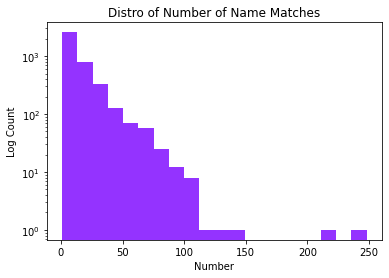

In [56]:
plt.hist(fil_dat_rev[fil_dat_rev['rev_len'] > 0]['rev_len'], bins = 20, color = '#9433ff')
plt.yscale('log')
plt.title('Distro of Number of Name Matches')
plt.xlabel('Number')
plt.ylabel('Log Count')
plt.show()
plt.close()

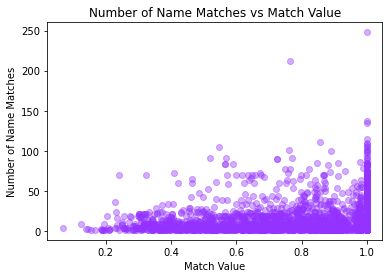

In [60]:
plt.scatter(fil_dat_rev[fil_dat_rev['rev_len'] > 0]['match_value'], fil_dat_rev[fil_dat_rev['rev_len'] > 0]['rev_len'], alpha = 0.4, color = '#9433ff')
plt.title('Number of Name Matches vs Match Value')
plt.xlabel('Match Value')
plt.ylabel('Number of Name Matches')
plt.show()
plt.close()